# Example 4: Flexural parameters at single grid cell

All the previous examples have led us to the calculation of the wavelet admittance and coherence functions at every grid cell. However, the main purpose ot `PlateFlex` is to estimate (and map) the flexural parameters of the lithosphere from the inversion of the admittance and coherence functions. We will explore this step-by-step again, starting with the estimation of flexural parameters at a single grid cell.

Let's start again by loading the topography data into a `TopoGrid` object and the Bouguer gravity anomaly data into a `BougGrid` object, which are then both inserted into a `Project` object. 

In [1]:
import numpy as np
import pandas as pd
from plateflex import TopoGrid, BougGrid, Project

# Read header (first line) of data set to get grid parameters
xmin, xmax, ymin, ymax, zmin, zmax, dx, dy, nx, ny = \
pd.read_csv('../data/Topo_NA.xyz', sep='\t', nrows=0).columns[1:].values.astype(float)

# Change type of nx and ny to integers
nx = int(nx); ny = int(ny)

# Read data 
topodata = pd.read_csv('../data/Topo_NA.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]
bougdata = pd.read_csv('../data/Bouguer_NA.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]

# Load the data as `plateflex` TopoGrid and BougGrid objects
topo = TopoGrid(topodata, dx, dy)
boug = BougGrid(bougdata, dx, dy)

# Create contours
contours = topo.make_contours(0.)

# Make mask 
mask = (topo.data < -500.)

# Define new project
project = Project(grids=[topo, boug])

# Initialize project
project.init()

# Calculate wavelet admittance and coherence
project.wlet_admit_coh()

# Take random cell value within grid and set as attribute
project.cell = (250, 100)

<Figure size 640x480 with 2 Axes>

We are ready to estimate the flexural parameters for the specified grid cell. Before going further, let's remind ourselves of the following: 

In [3]:
project.__dict__

{'inverse': 'L2',
 'grids': [<plateflex.classes.TopoGrid at 0x122123400>,
 'mask': None,
 'initialized': True,
 'rhoc': None,
 'zc': None,
 'water_depth': array([[4773.43994141, 4770.30712891, 4736.65576172, ..., 3779.10644531,
         3609.01147461, 4773.43994141],
        [4778.16992188, 4795.12939453, 4804.34228516, ..., 3775.15356445,
         3628.46166992, 4778.16992188],
        [4829.92382812, 4865.66894531, 4797.75439453, ..., 3748.75512695,
         3561.30175781, 4829.92382812],
        ...,
        [  45.76174164,   38.02427292,   21.88285637, ..., 2385.19848633,
         2406.828125  ,   45.76174164],
        [  25.40994644,   42.38096237,   28.78584862, ..., 2342.10888672,
         2302.70336914,   25.40994644],
        [  31.34422684,   43.00458145,   29.85589027, ..., 2209.63891602,
         2426.28808594,   31.34422684]]),
 'k': array([2.60106395e-06, 3.22337138e-06, 3.99456654e-06, 4.95027100e-06,
        6.13462882e-06, 7.60234554e-06, 9.42121512e-06, 1.16752513e-05

* `rhoc` is `None`
* `zc` is `None`

This implies that the softwares will use default vaules for those fields during estimation of the flexural parameters.

Let's now explore the default parameters of the model.

In [4]:
# First we need to import `plateflex`
import plateflex

# Then print out the default parameters
plateflex.get_conf_flex()

Global model parameters currently in use by plateflex:
------------------------------------------------------
[Crustal thickness]        zc (float):     35000 m
[Mantle density]           rhom (float):   3200 kg/m^3
[Crustal density]          rhoc (float):   2700 kg/m^3
[Water density]            rhow (float):   1030 kg/m^3
[Air density]              rhoa (float):   0 kg/m^3
[Fluid density]            rhof (float):   0 kg/m^3
[Water depth]              wd (float):     -0 m
[Bouguer analysis?]        boug (int):     1 ; True


In this default model, the crust is 35 km thick, has a density of 2700 kg/m^3, the mantle density is 3200 kg/m^3 and water depth has been set to 0 m. Furthermore, the fluid density (fluid above topography) has been set to that of air (0 kg/m^3). Finally, during initialization of the project, the software recognized that the `GravGrid` object was of type `BougGrid`, which updated the `boug` variable to 1 (`True`). 

<div class="alert alert-block alert-info">
<b>Note:</b> The variables `rhof` and `wd` do not need to be changed. The code will automatically extract the water depth at the specified grid cell and determined whether to use `rhow` or `rhoa` for the fluid density above the topography.
</div>

<div class="alert alert-block alert-warning">
<b>Warning 1:</b> It is highly recommmended not to change the variable `boug`, since the calculation of the predicted admittance and coherence depends on that flag and will give erroneous results if mi-used.
</div>

<div class="alert alert-block alert-warning">
<b>Warning 2:</b> Following this note, it is the responsibility of the user to specify the right type of `GravGrid` to use when loading the data set of gravity anomalies.
</div>

Although some of these values appear to be reasonable, it is always possible to change some of them - in particular `rhoc`, `rhom`, `zc`, `rhow` or `rhoa` (although the default values for `rhom`, `rhow` and `rhoa` are fairly good estimates for this particular problem). 

In [5]:
# Change crustal thickness and density
from plateflex.flex import conf_flex as cf
cf.zc = 40.e3 # in meters
cf.rhoc = 2670. 

plateflex.get_conf_flex()

Global model parameters currently in use by plateflex:
------------------------------------------------------
[Crustal thickness]        zc (float):     40000 m
[Mantle density]           rhom (float):   3200 kg/m^3
[Crustal density]          rhoc (float):   2670 kg/m^3
[Water density]            rhow (float):   1030 kg/m^3
[Air density]              rhoa (float):   0 kg/m^3
[Fluid density]            rhof (float):   0 kg/m^3
[Water depth]              wd (float):     -0 m
[Bouguer analysis?]        boug (int):     1 ; True


Next, you probably remember that during initialization, the `inverse` attribute was set to `L2` (see above). This implies that by default the software will use a non-linear least-squares method to estimate the flexural parameters. The two available options are `'L2'` and `'bayes'`, the latter based on a probabilistic estimation method based on bayesian inference. A couple of things to note:

<div class="alert alert-block alert-info">
<b>Note 1:</b> The two methods should give very similar results. Differences arise mainly because the 'bayes' approach draws a finite number of samples from the posterior distribution, and equality is achieved only for infinite sampling of the posterior. 
</div>

<div class="alert alert-block alert-info">
<b>Note 2:</b> The 'L2' approach is <b>MUCH</b> faster than the 'bayes' approach. However, the 'bayes' approach provides useful statistics for the inference step. 
</div>

Let's examine the estimation of the flexural parameters using the default `'L2'` approach, by only specifying the cell location (tuple):

          mean       std      chi2
Te  134.964151  5.946390  7.314674
F     0.693254  0.020005  7.314674


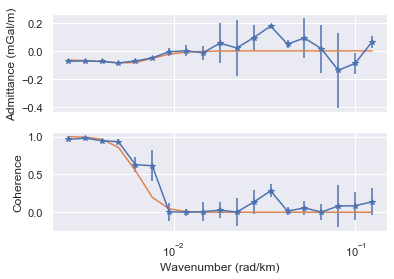

In [17]:
# Perform estimation
project.estimate_cell((250, 200))

# Print summary
print(project.summary)

# Plot observed and predicted (best-fit) functins:
project.plot_functions()

Now do the same using the `'bayes'` approach

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [F]
>Slice: [Te]
logp = -110.58: 100%|██████████| 114/114 [00:00<00:00, 4300.26it/s] 


          mean        sd  mc_error     hpd_2.5    hpd_97.5       n_eff  \
Te  133.734074  6.604063  0.262095  121.259782  146.942171  596.680878   
F     0.688778  0.021439  0.000810    0.647115    0.729730  598.310803   

        Rhat  
Te  1.001721  
F   1.000448  


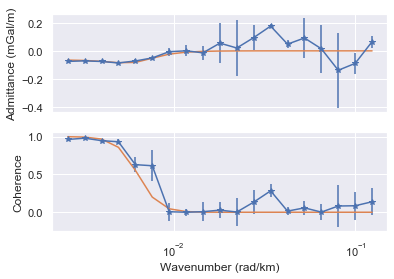

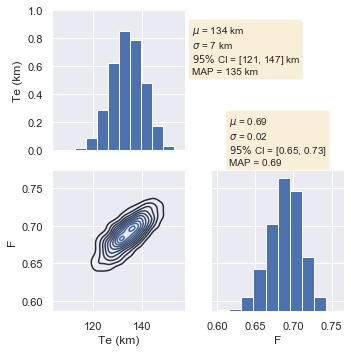

In [19]:
# Switch inverse attribute
project.inverse = 'bayes'

# Perform estimation
project.estimate_cell((250, 200))

# Print summary
print(project.summary)

# Plot observed and predicted (best-fit) functins:
project.plot_functions()

# Plot stats for estimate
project.plot_bayes_stats()

In the background, the method has done a joint inversion of the admittance and coherence functions to estimate the flexural parameters. This is the default setting for the estimation, but this can be changed by specifying a different `atype` values (default: `atype='joint'`; other available options are `atype='admit'` and `atype='coh'`):

          mean       std      chi2
Te  147.067777  8.240065  13.29238
F     0.695959  0.018311  13.29238


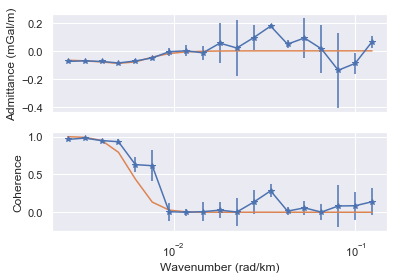

         mean        std      chi2
Te  161.94524  81.173298  1.415632
F     0.05266   0.056694  1.415632


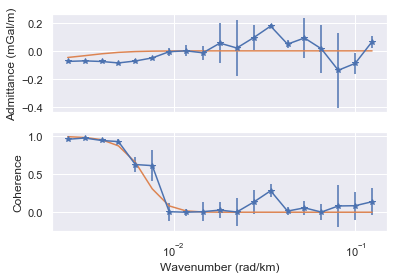

In [22]:
# Switch back to `L2`
project.inverse = 'L2'

# Perform estimation, print summary and plot
project.estimate_cell((250, 200), atype='admit')
print(project.summary)
project.plot_functions()

# Perform estimation, print summary and plot
project.estimate_cell((250, 200), atype='coh')
print(project.summary)
project.plot_functions()

And the same with the `'bayes'` approach

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [F]
>Slice: [Te]
logp = -118.12: 100%|██████████| 81/81 [00:00<00:00, 4524.66it/s]  


          mean        sd  mc_error     hpd_2.5    hpd_97.5        n_eff  \
Te  146.071397  9.070156  0.266458  127.859586  162.694138  1207.191544   
F     0.690860  0.018446  0.000540    0.656652    0.726933  1102.314779   

        Rhat  
Te  0.999784  
F   1.000611  


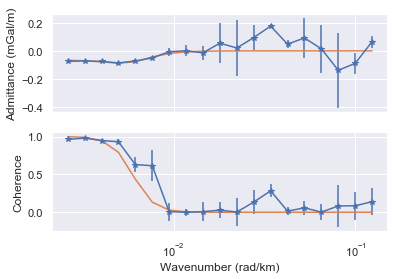

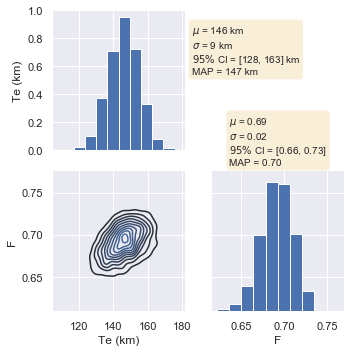

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [F]
>Slice: [Te]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:00<00:00, 4451.22draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
logp = -21.441: 100%|██████████| 348/348 [00:00<00:00, 4616.55it/s] 


          mean         sd  mc_error    hpd_2.5    hpd_97.5      n_eff  \
Te  146.021034  26.848659  2.304999  97.127078  196.313864  36.634809   
F     0.079539   0.057598  0.004666   0.028100    0.167315  60.742244   

        Rhat  
Te  1.013768  
F   1.006174  


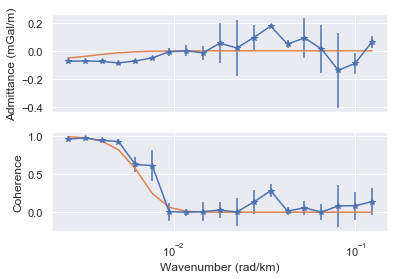

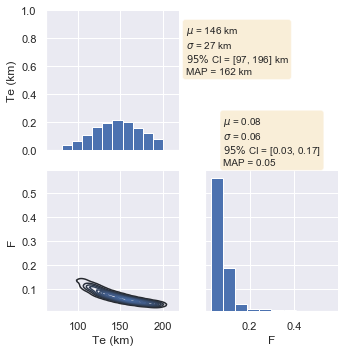

In [25]:
# Switch again to `bayes`
project.inverse = 'bayes'

# Perform estimation, print summary and plot
project.estimate_cell((250, 200), atype='admit')
print(project.summary)
project.plot_functions()
project.plot_bayes_stats()

# Perform estimation, print summary and plot
project.estimate_cell((250, 200), atype='coh')
print(project.summary)
project.plot_functions()
project.plot_bayes_stats()

You are now ready to map out these parameters! Check out Example 5.